## Loading of Stringer spontaneous data

includes some visualizations

In [6]:
# @title Install dependencies
!pip install umap-learn --quiet

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [8]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [9]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [10]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [11]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


<ipython-input-7-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


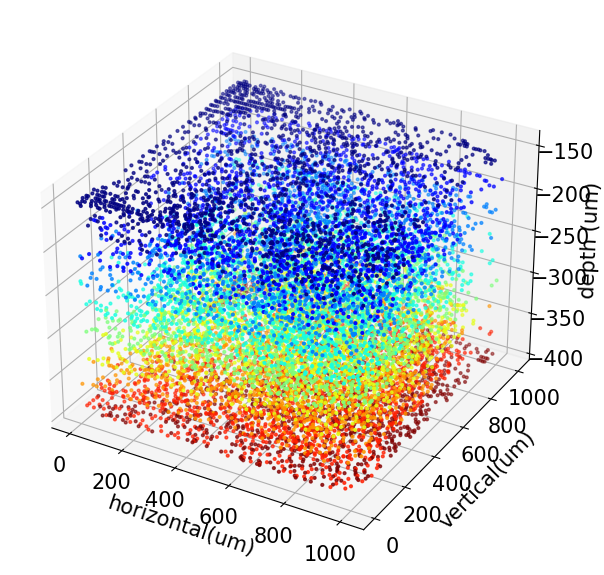

In [7]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

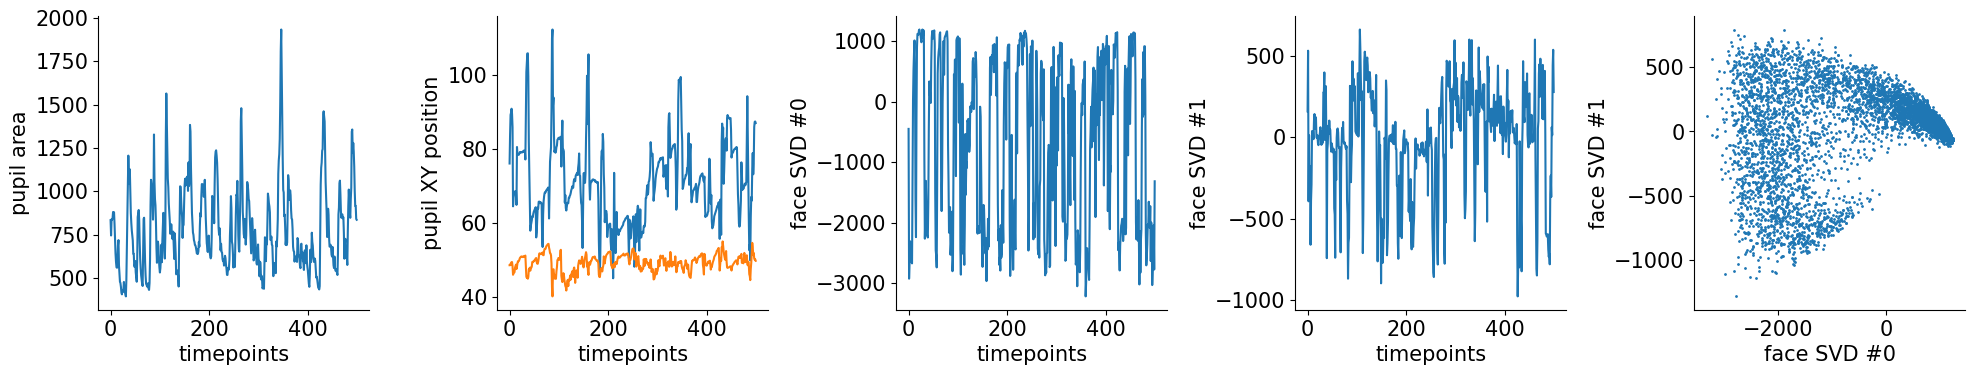

In [8]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [9]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

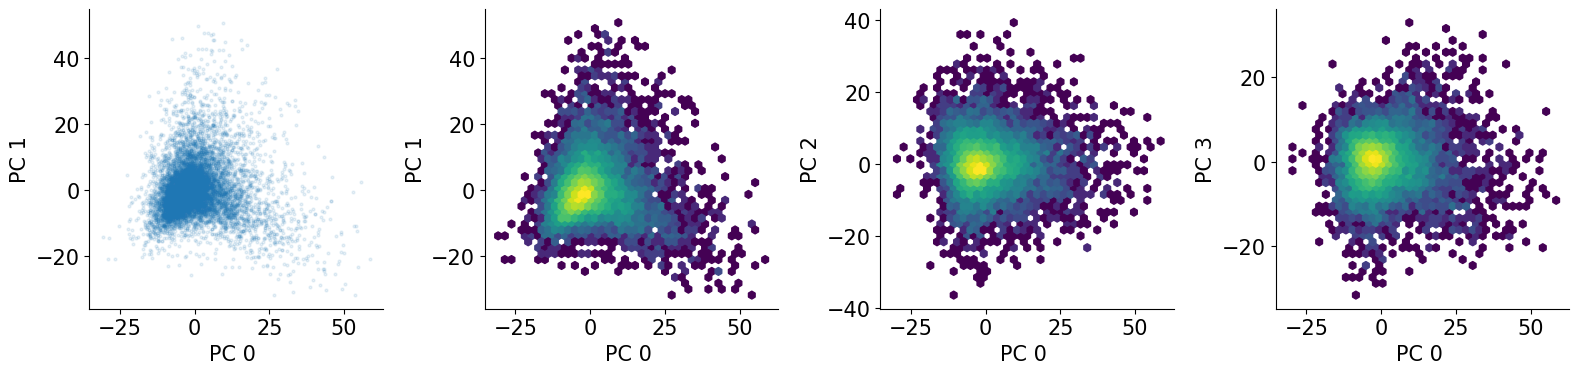

In [10]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

ax = plt.subplot(1, 5, 3)
plt.hexbin(X[:, 0], X[:, 2], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 2', alpha=.1)

ax = plt.subplot(1, 5, 4)
plt.hexbin(X[:, 0], X[:, 4], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 3', alpha=.1)


plt.show()

In [11]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 3 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X) #Fit the PCAs

In [12]:
# @title 3d scatterplot of first 3 principal components
import plotly.express as px

embed /= embed.max()
x_, y_, z_ = embed.T

fig = px.scatter_3d({"PC1":x_, "PC2":y_, "PC3":z_,},
                    x = "PC1", y = "PC2", z = "PC3",
)
fig.update_traces(marker=dict(color="blue",size=1), opacity=0.8 )
fig.show()

In [13]:
embed_flat = embed.flatten()
isort = np.argsort(embed_flat)
#isort2 = np.argsort(embed)
comp = 2
#zscore of neural activity
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
# RasterMap = uniform_filter1d(Z[isort2[:,comp], :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

IndexError: ignored

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons', title=f"raster of sorted neurons compon {comp+1}")
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

In [ ]:
data = dat['stat'][0,:].flatten()
tmp = [x.flatten() for x in data]

In [ ]:
unpacked = list()

for x in tmp:
  unpacked.append(np.asarray(x))

print(len(unpacked))
print(unpacked[0])

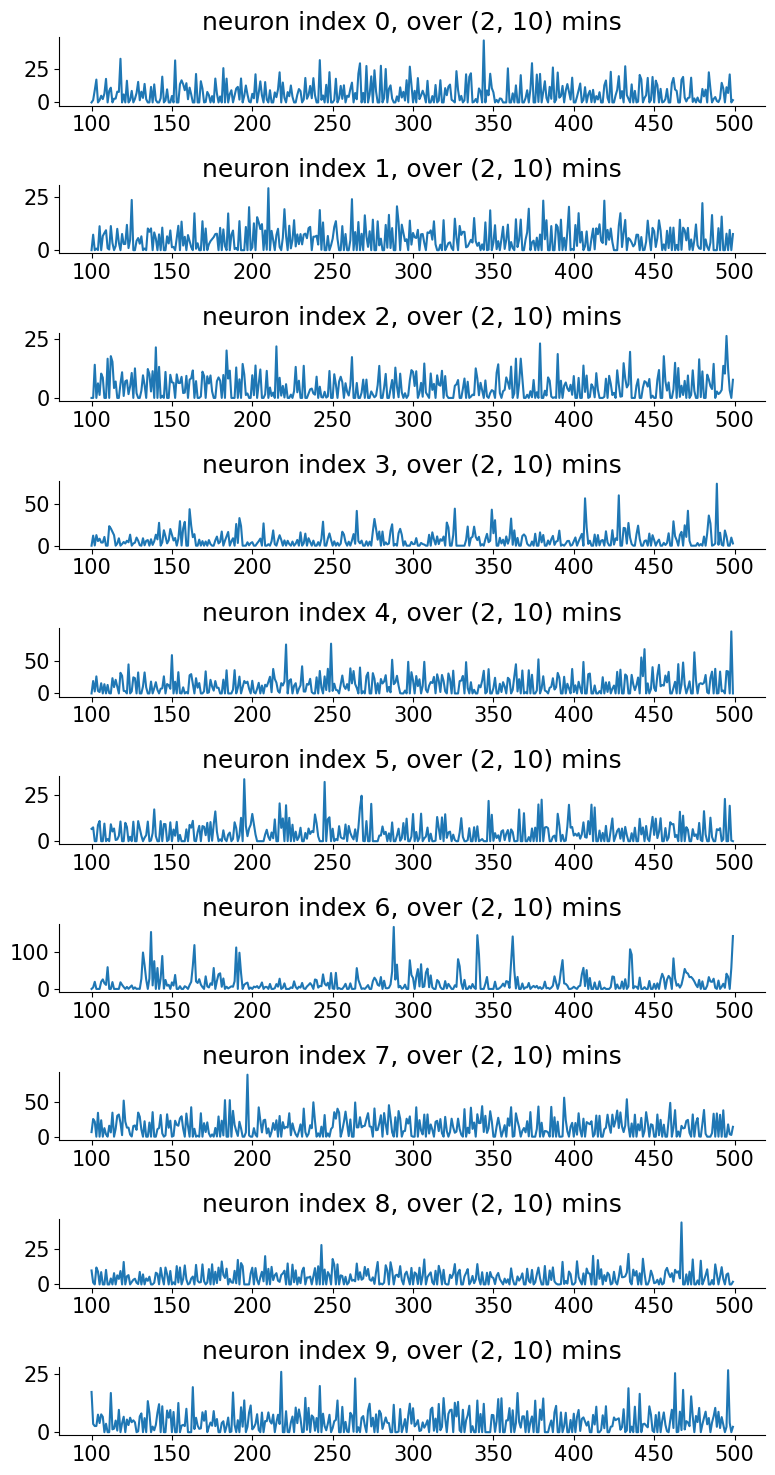

In [23]:
def plot_activity(spike_data, num, *, win_length:int=500):
  assert type(win_length) != list

  num_subplots = num
  t_bin = 1.2
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = spike_data[:num_subplots]
  fig, ax = plt.subplots(nrows=num_subplots, ncols=1, figsize=(8, num_subplots*1.5))
  for idx, activity in enumerate(subset):
    ax[idx].plot(np.arange(lower, upper), activity[lower:upper])
    ax[idx].set(title=f"neuron index {idx}, over {span} mins")
  fig.show()


plot_activity(dat['sresp'], 10, win_length = (100,500))

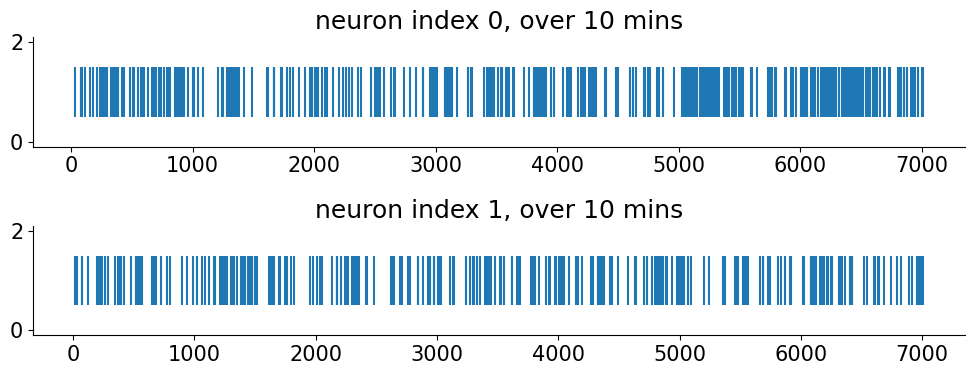

In [25]:
import copy
def raster_plot(spike_data, num, *, tol= 1, win_length:int=500):
  assert type(win_length) != list

  t_bin = 1.2
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = copy.deepcopy(spike_data[:num])
  Z = np.nan_to_num(zscore(subset, axis = 1))

  fig, ax = plt.subplots(nrows=num, ncols=1, figsize=(10, num*2))
  for idx, raster in enumerate(Z):
    tmp = np.where(raster>=tol, 1, 0 )
    events = np.argwhere(tmp>0).squeeze()
    ax[idx].eventplot(events)
    ax[idx].set(title=f"neuron index {idx}, over {span} mins")
  fig.show()

raster_plot(dat['sresp'], 2, tol=1.96, win_length = 500)

In [ ]:
def binary(arr):
  mask = dict()
  Z = zscore(arr, axis = 1)
  for idx, row in enumerate(Z):
    print(row)
    mask[idx] = row.std()
  return mask,Z

example = dat['sresp'][:1]
example_zscore = zscore(example, axis=1)
cut_off = example.std()
print(example)
print(example_zscore)
print(np.where(example_zscore>= 2*cut_off, 1, 0))


In [ ]:
plt.plot(example_zscore[0])


In [ ]:
squeezed = example_zscore.squeeze()
tmp = np.where(squeezed >= 1.7, 1, 0)
events = np.argwhere(tmp>0).squeeze()
plt.eventplot(events)

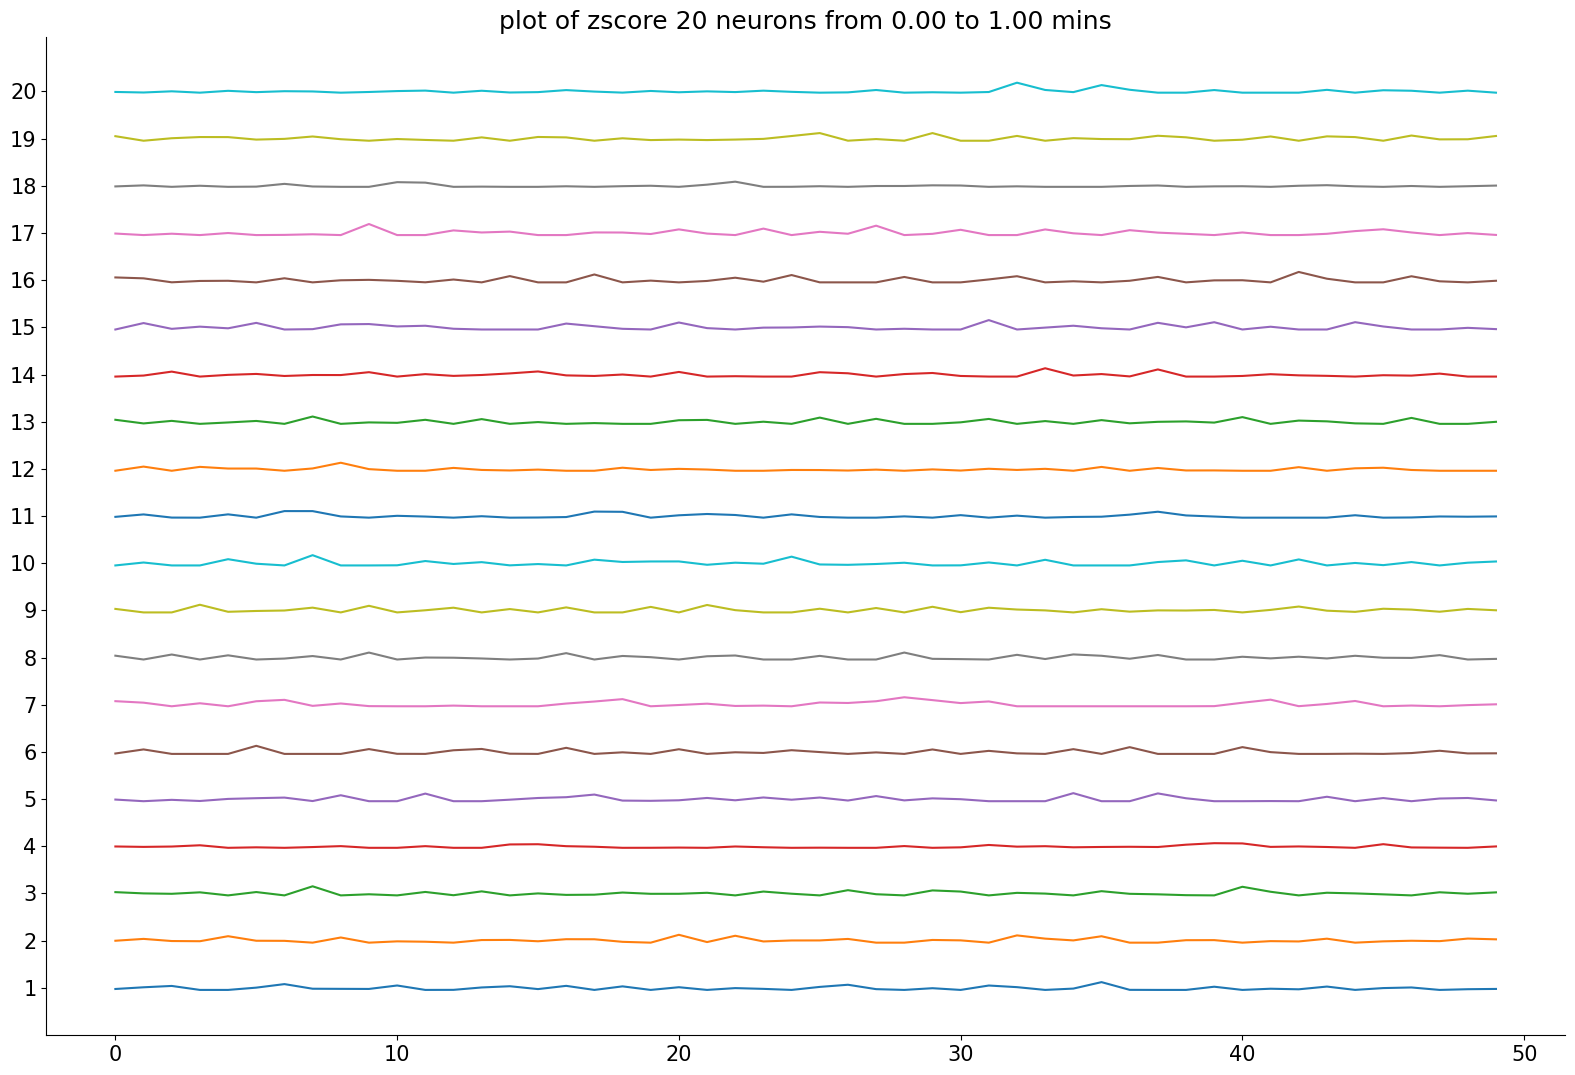

In [22]:
def plot_activity(spike_data, num, *, win_length:int=500, sep:int = 20):
  assert type(win_length) != list

  t_bin = 1.2
  ticks = np.arange(0, num*sep , sep)
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  elif win_length == None:
    lower = 0
    upper = spike_data.shape[1]
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = zscore(spike_data[:num],axis=1)
  subset = subset + ticks[:, np.newaxis]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 11))
  ax.plot(np.arange(lower, upper), subset[:, lower:upper].T)
  ax.set_yticks(ticks)
  ax.set_yticklabels(np.arange(1,num+1))
  ax.set(title=f"plot of zscore {num} neurons from {(lower*1.2)/60:.2f} to {(upper*1.2)/60:.2f} mins")
  fig.show()


plot_activity(dat['sresp'], 20, win_length= 50)#win_length = (100,700))

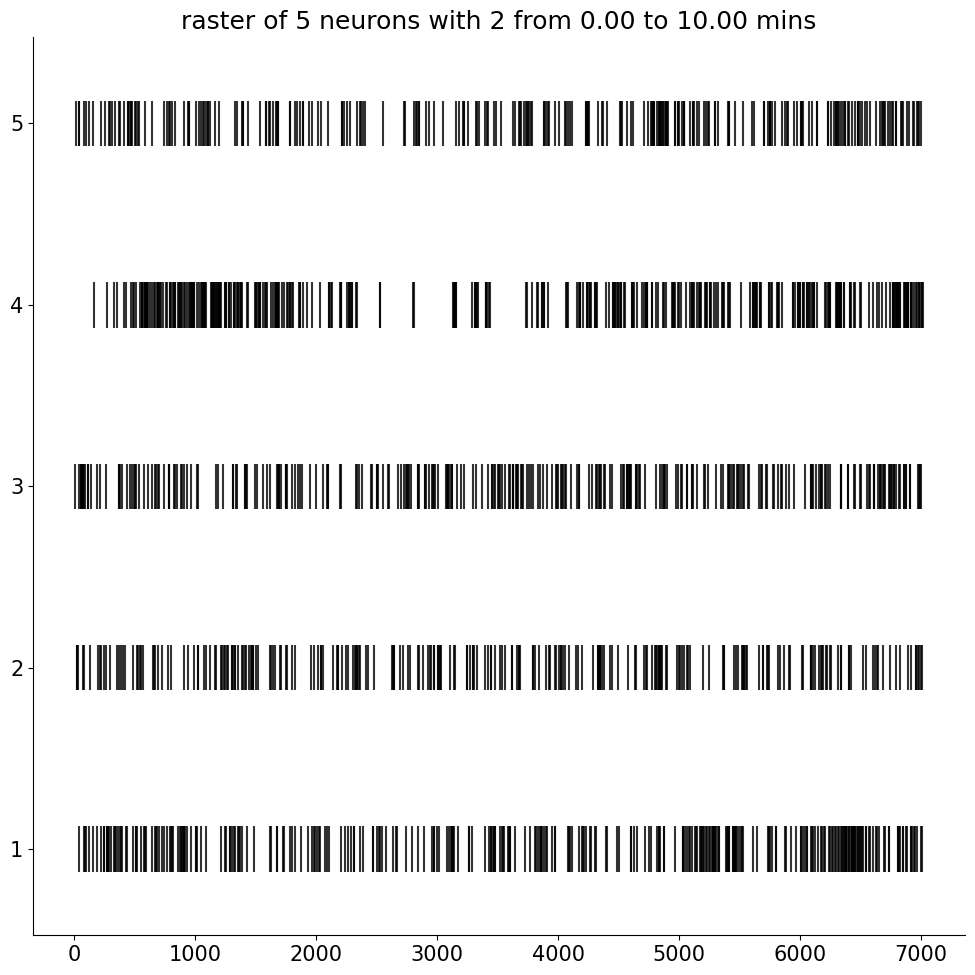

In [51]:
import copy
def raster_plot_2(spike_data, num, *, std:int =2, win_length:int=500, ):
  assert type(win_length) != list


  t_bin = 1.2
  ticks = np.arange(0, num)
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = copy.deepcopy(spike_data[:num])
  Z = np.nan_to_num(zscore(subset, axis = 1))
  tol = Z.std() * std

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, num*2))
  tmp = np.where(Z>=tol, 1, 0 )
  events = list()
  for row in tmp:
    events.append(np.argwhere(row>0))
  # print(events.shape)
  # print(tmp.shape)
  for idx, event in enumerate(events):
    ax.eventplot(event, lineoffsets=[idx]* len(event), linelengths= 0.25, colors='k',alpha=0.8,)
  ax.set_yticks(ticks)
  ax.set_yticklabels(np.arange(1,num+1))
  ax.set(title=f"raster of {num} neurons with {std} from {(lower*1.2)/60:.2f} to {(upper*1.2)/60:.2f} mins")

  # fig.show()

raster_plot_2(dat['sresp'], 5, std = 2, win_length = 500)